# ASCAT data from EUMETSAT - the easy way

Note: This notebook depends on functionality to be released in the next version of this package. If you have installed `ascat` via PyPi, you will need to install the current version of the master branch from GitHub instead:
```bash
pip uninstall ascat
pip install git+https://github.com/TUW-GEO/ascat.git
```

It also depends on version 3.0.0 of the `eodag` package, which is in pre-release at the time of writing and is not a dependency of this package. To install the proper version, you can run:
```bash
pip install eodag==3.0.0b3
```

This newest version of `eodag` includes support for the EUMETSAT Data Store, which will soon be available in the standard PyPi release of the package.

In [1]:
from pathlib import Path

import xarray as xr

from eodag import EODataAccessGateway
from eodag import setup_logging
from rasterio.crs import CRS
from ascat.eumetsat.level2 import AscatL2File

setup_logging(verbose=1, no_progress_bar=True)
dag = EODataAccessGateway()

We can easily access HSAF ASCAT soil moisture products from the EUMETSAT Data Store using EODAG.

EODAG ([Earth Observation Data Access Gateway](https://eodag.readthedocs.io/en/latest/index.html)) is a python library that provides a unified API to search, download and manage EO data from multiple providers.

We could, alternatively, use EUMETSAT's own Python library ([EUMDAC](https://user.eumetsat.int/resources/user-guides/eumetsat-data-access-client-eumdac-guide)), but EODAG provides a more user-friendly interface, supports multiple providers, and comes with functionality for tracking data that have already been downloaded.

To set things up, we just need to get an API key and provide it to EODAG. If you do not already have an account with EUMETSAT, you can create one [here](https://eoportal.eumetsat.int/userMgmt/register.faces). Then, go to the [API information page](https://api.eumetsat.int/api-key/) and log in to get your consumer key and consumer secret.

You can follow the directions on [Configure EODAG](https://eodag.readthedocs.io/en/latest/getting_started_guide/configure.html#configure) to save your credentials (consumer key as "username" and consumer secret as "password") in EODAG's configuration file.

Alternatively, you can configure authentication from python itself as follows:

In [2]:
# dag.update_providers_config("""
#     eumetsat_ds:
#         auth:
#             username: placeholder_consumer_key
#             password: placeholder_consumer_secret
# """)

Now that our access to the Data Store is configured, let's look at what ASCAT products it has. The Data Access Gateway we created earlier comes with a handy `guess_product_type()` method, which will try its best to return the IDs of product types that go with a particular string. Since we're looking for ASCAT data, let's just try that:

In [3]:
dag.guess_product_type("ASCAT")

['METOP_OSI_150A',
 'METOP_OSI_150B',
 'METOP_ASCSZF1B',
 'METOP_OSI_104',
 'METOP_ASCSZFR02',
 'METOP_ASCSZOR02',
 'METOP_ASCSZRR02',
 'METOP_SOMO12',
 'METOP_SOMO25',
 'METOP_ASCSZO1B',
 'METOP_ASCSZR1B',
 'MO_WIND_GLO_PHY_CLIMATE_L4_MY_012_003',
 'MO_WIND_GLO_PHY_L4_NRT_012_004',
 'MO_WIND_GLO_PHY_L4_MY_012_006',
 'MO_WIND_GLO_PHY_L3_MY_012_005',
 'MO_WIND_GLO_PHY_L3_NRT_012_002']

We've got a list of products here but the names aren't necessarily the most enlightening. I see `METOP_SOMO12` and `METOP_SOMO25` in there - you could guess that "SOMO" is short for "soil moisture". We can get a bit more information about it using the `list_product_types` method of the Data Access Gateway. This lists information on every product from a provider, so we have to filter it a bit ourselves.

In [4]:
[p for p in dag.list_product_types(provider="eumetsat_ds") if 'SOMO' in p['ID']]

[{'ID': 'METOP_SOMO12',
  'abstract': 'The Soil Moisture (SM) product is derived from the Advanced SCATterometer (ASCAT)\nbackscatter observations and given in swath orbit geometry (12.5 km sampling). This\nSM product provides an estimate of the water content of the 0-5 cm topsoil layer,\nexpressed in degree of saturation between 0 and 100 [%]. The algorithm used to\nderive this parameter is based on a linear relationship of SM and scatterometer\nbackscatter and uses change detection techniques to eliminate the contributions of\nvegetation, land cover and surface topography, considered invariant from year to\nyear. Seasonal vegetation effects are modelled by exploiting the multi-angle viewing\ncapabilities of ASCAT. The SM processor has been developed by Vienna University of\nTechnology (TU Wien). Note that some of the data are reprocessed. Please refer to\nthe associated product validation reports or product release notes for further\ninformation.\n',
  'instrument': 'ASCAT',
  'platf

OK, these are indeed soil moisture products. One is on a 12.5km Swath Grid and the other is on 25km. These products and all of the products in the Data Store with IDs beginning with `METOP_ASC` can be read using the `AscatL1File` or `AscatL2File` readers provided by this package. Let's work with the high-resolution soil moisture data for now: `METOP_SOMO12`.

We can tell EODAG to search the EUMETSAT Data Store for products matching our desired product type, geographic bounding box, and time range using the Data Access Gateway's `search()` method.

In [5]:
footprint = {'lonmin': 6, 'latmin': 43, 'lonmax': 14, 'latmax': 49}
dates = ('2018-05-01', '2018-05-31')
product_type = "METOP_SOMO12"
products = dag.search_all(productType=product_type,
                        geom=footprint,
                        start=dates[0],
                        end=dates[1],
                        provider='eumetsat_ds',
                        platform='Metop-A')
print(f"matched {len(products)} products")

matched 85 products


A quick preview of our first and last five matches - We can tell from the filenames that we have indeed found files covering the desired date range.

In [6]:
products[:5] + products[-5:]

SearchResult([EOProduct(id=ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180501173600Z_20180501191458Z_N_O_20180501191536Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180502085400Z_20180502103258Z_N_O_20180502103342Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180530091200Z_20180530105358Z_N_O_20180530105244Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180530173300Z_20180530191458Z_N_O_20180530191354Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180530191500Z_20180530205658Z_N_O_20180530205546Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180531085100Z_20180531103258Z_N_O_20180531103200Z, provider=eumetsat_ds),
              EOProduct(id=ASCA_SMR_02_M02_20180531185400Z_20180531203558Z_N_O_20180531203420Z, provider=eumetsat_ds)])

We can download them all with one line. EODAG will download all products to your computer's temporary files folder by default, but it is also possible to configure the downloads directory for each provider just as we did the authentication. Again, this can be done in EODAG's configuration file or from python itself:

In [7]:
import os
workspace = '/tmp/eodag_eumetsat_ds'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

dag.update_providers_config(f"""
    eumetsat_ds:
        download:
            output_dir: {os.path.abspath(workspace)}
""")

***NB!*** Since the data is stored as hourly swath files, you will end up with a lot of data you do not necessarily need (assuming your region of interest is smaller than, say, a continent). We will go through a workflow for extracting exactly the data we want and saving it as NetCDF files, this way we can delete the huge swath files afterwards. If you want to do that now, go ahead and skip to [Converting Native files to NetCDF](#Converting-Native-files-to-NetCDF)



The `download` method also returns the filepaths where the products end up. Note that if a product has already been downloaded, EODAG will not download it again if you request it a second time, it will just return a path to the existing file! This is nice behaviour most of the time, but be careful if a file ends up changed or corrupted (e.g. if the download is interrupted and only partially complete). You'll have to delete it from its directory to get EODAG to re-download it.

In [8]:
filenames = dag.download_all(products)

In [9]:
filenames[:10]

['/tmp/ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z',
 '/tmp/ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z',
 '/tmp/ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z',
 '/tmp/ASCA_SMR_02_M02_20180503101200Z_20180503115358Z_N_O_20180503115230Z',
 '/tmp/ASCA_SMR_02_M02_20180504081200Z_20180504095058Z_N_O_20180504095206Z',
 '/tmp/ASCA_SMR_02_M02_20180504181200Z_20180504195358Z_N_O_20180504195258Z',
 '/tmp/ASCA_SMR_02_M02_20180505175100Z_20180505193258Z_N_O_20180505193220Z',
 '/tmp/ASCA_SMR_02_M02_20180506090900Z_20180506105058Z_N_O_20180506105019Z',
 '/tmp/ASCA_SMR_02_M02_20180506191200Z_20180506205358Z_N_O_20180506205249Z',
 '/tmp/ASCA_SMR_02_M02_20180507185100Z_20180507203258Z_N_O_20180507203154Z']

EODAG has downloaded all the data we requested into the directory we set - but the actual files we want are packaged inside subdirectories for each swath. We want to get a list of paths to the actual files - we can make a `pathlib.Path` object out of the parent directory and use its `rglob` (recursive `glob`) method to get all `.nat` files contained in the directory.

In [10]:
filepaths = [f for file in filenames for f in Path(file).rglob("*.nat") ]
filepaths[:10]

[PosixPath('/tmp/ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z/ASCA_SMR_02_M02_20180501091500Z_20180501105358Z_N_O_20180501105428Z.nat'),
 PosixPath('/tmp/ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z/ASCA_SMR_02_M02_20180501191500Z_20180501205658Z_N_O_20180501205618Z.nat'),
 PosixPath('/tmp/ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z/ASCA_SMR_02_M02_20180502185400Z_20180502203558Z_N_O_20180502203446Z.nat'),
 PosixPath('/tmp/ASCA_SMR_02_M02_20180503101200Z_20180503115358Z_N_O_20180503115230Z/ASCA_SMR_02_M02_20180503101200Z_20180503115358Z_N_O_20180503115230Z.nat'),
 PosixPath('/tmp/ASCA_SMR_02_M02_20180504081200Z_20180504095058Z_N_O_20180504095206Z/ASCA_SMR_02_M02_20180504081200Z_20180504095058Z_N_O_20180504095206Z.nat'),
 PosixPath('/tmp/ASCA_SMR_02_M02_20180504181200Z_20180504195358Z_N_O_20180504195258Z/ASCA_SMR_02_M02_20180504181200Z_20180504195358Z_N_O_20180504195258Z.nat'),
 PosixPath('/tmp/ASCA_SMR_02_M02_2018050

Now we can use the AscatL2EpsFile class from the `ascat` package to read the data from the filenames, and even convert the data to an `xarray.Dataset` object for easier manipulation.

In [11]:
eps_file = AscatL2File(filepaths)
ds, metadata = eps_file.read(to_xarray=True)
ds

<xarray.Dataset> Size: 4GB
Dimensions:           (obs: 22513920, beam: 3)
Coordinates:
    lon               (obs) float32 90MB 28.92 28.75 28.58 ... -28.59 -28.88
    lat               (obs) float32 90MB 54.82 54.88 54.93 ... 67.38 67.39 67.4
    time              (obs) datetime64[ns] 180MB 2018-05-01T09:15:00 ... 2018...
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 270MB 0.998 0.998 1.0 ... 0.0 0.0 0.0
    sat_track_azi     (obs) float32 90MB 198.4 198.4 198.4 ... 202.6 202.6 202.6
    abs_line_number   (obs) int32 90MB 617046720 617046720 ... 619174270
    param_db_version  (obs) uint16 45MB 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3
    warp_nrt_version  (obs) uint16 45MB 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3
    node_num          (obs) float64 180MB 1.0 2.0 3.0 4.0 ... 80.0 81.0 82.0
    ...                ...
    frozen_prob       (obs) float32 90MB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wetland           (obs) float32 90MB 1.0 2.0 3.0 1.0 1.0 ... nan nan nan nan
    topo              (obs) float32 90MB 1.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    kp                (obs, beam) float32 270MB 0.0362 0.0362 ... 0.0446 0.0436
    swath_indicator   (obs) float32 90MB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    sat_id            (obs) float64 180MB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
Attributes:
    spacecraft_id:  2
    sat_id:         3

Note: When combining swath data into an xarray dataset, any metadata attributes that are not the same across all swaths get dropped from the final dataset - if you're reading multiple swaths from a single satellite then the `orbit_start` attribute will be dropped.

However, all original metadata is preserved and returned by the `read` method as a list of dictionaries corresponding to each source file, if there is any need for the original metadata. For this tutorial, though, we no longer need the original metadata.

In [12]:
metadata[:10]

({'spacecraft_id': 2, 'orbit_start': np.uint32(59835), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59841), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59855), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59864), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59877), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59883), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59897), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59906), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59912), 'sat_id': np.int64(3)},
 {'spacecraft_id': 2, 'orbit_start': np.uint32(59926), 'sat_id': np.int64(3)})

This dataset has two dimensions: `obs` and `beam`. The `obs` dimension represents the individual observations taken by the satellite at different grid points. It can be thought of almost as a time dimension, except that the times of the observations are not necessarily unique. The `beams` dimension represents the three sensors on each side of the METOP satellite - the fore, mid, and aft beams.

Most of its variables only have the `obs` dimension, but some have data for each beam.

As a first order of business, let's clip this data down to what we actually want. Since METOP data is provided as hour-long swath tracks, each file contains a lot of data we don't want if we're only interested in a specific region.

We also might want to mask out values that are likely to be incorrect due to high probability of snow cover or frozen soil.

In [13]:
alps_ds = ds.sel(obs=(ds.lon > footprint["lonmin"])
            & (ds.lat > footprint["latmin"])
            & (ds.lon < footprint["lonmax"])
            & (ds.lat < footprint["latmax"]))

# mask data with >80% chance of being frozen soil or snow-covered.
alps_ds = alps_ds.where(((alps_ds.snow_prob < 80)
                        & (alps_ds.frozen_prob < 80)))
alps_ds

<xarray.Dataset> Size: 17MB
Dimensions:           (obs: 88803, beam: 3)
Coordinates:
    lon               (obs) float32 355kB 13.97 13.92 13.88 ... 7.621 7.573
    lat               (obs) float32 355kB 43.61 43.5 43.39 ... 43.1 43.13 43.03
    time              (obs) datetime64[ns] 710kB 2018-05-01T09:18:54.375000 ....
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 1MB nan nan nan nan ... nan nan nan
    sat_track_azi     (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    abs_line_number   (obs) float64 710kB nan nan nan nan ... nan nan nan nan
    param_db_version  (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    warp_nrt_version  (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    node_num          (obs) float64 710kB nan nan nan nan ... nan nan nan nan
    ...                ...
    frozen_prob       (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    wetland           (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    topo              (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    kp                (obs, beam) float32 1MB nan nan nan nan ... nan nan nan
    swath_indicator   (obs) float32 355kB nan nan nan nan ... nan nan nan nan
    sat_id            (obs) float64 710kB nan nan nan nan ... nan nan nan nan
Attributes:
    spacecraft_id:  2
    sat_id:         3

This looks more manageable now, but it's still not in a nice format to work with, since every observation is just a point scattered randomly on the map. We'd much rather have things on some kind of a regular grid. We might even want them aggregated by time a bit, so that we have a cube of raster images we can work with in a more familiar way. With some smart resampling, this is possible.

There are various ways to do this, but TU Wien develops a packaged called `pygeogrids` that provides some useful functions for this. We can use its `grids.genreg_grid` function to generate a regularly-spaced grid globally or within specified lat/lon bounds, where each grid point has a unique ID. It also provides functions for using a kdtree to find the nearest grid points to an array of coordinates that are not necessarily on the grid. These two functionalities will make resampling a breeze.

Be sure to be careful when choosing a grid resolution - it should be relatively close to the sample spacing of the dataset, the closer the better. A tenth of a degree is a good ballpark figure for 12.5km ASCAT data in general, since it's equivalent to about 11.1km longitude at the equator and 11.1km latitude everywhere.

After generating the grid, we will find the nearest grid point to each observation in the dataset, as well as the distance between the observation and that grid point.

In [14]:
from pygeogrids.grids import genreg_grid

# generate a 0.1-degree-square grid across our area of interest
# the spacing of the grid should be on about the same scale as the actual spacing of the points in the swaths.
reg_grid = genreg_grid(0.1, 0.1,
                       minlat=footprint["latmin"], maxlat=footprint["latmax"],
                       minlon=footprint["lonmin"], maxlon=footprint["lonmax"])

# we can use the grid's kdTree to find the nearest grid point index (gpi) to each of an array
# of coordinates, as well as the distance to that nearest gpi. We will later use this distance
# for weighting.
distances, gpis = reg_grid.kdTree.find_nearest_index(alps_ds.lon, alps_ds.lat)
alps_ds["gpi_dist"] = ("obs", distances)
alps_ds["gpi"] = ("obs", gpis)
alps_ds["grid_lon"], alps_ds["grid_lat"] = [("obs", vals) for vals in reg_grid.gpi2lonlat(alps_ds["gpi"])]
alps_ds[["gpi", "gpi_dist", "grid_lon", "grid_lat", "sm"]]

<xarray.Dataset> Size: 4MB
Dimensions:   (obs: 88803)
Coordinates:
    lon       (obs) float32 355kB 13.97 13.92 13.88 13.97 ... 7.767 7.621 7.573
    lat       (obs) float32 355kB 43.61 43.5 43.39 43.25 ... 43.1 43.13 43.03
    time      (obs) datetime64[ns] 710kB 2018-05-01T09:18:54.375000 ... 2018-...
Dimensions without coordinates: obs
Data variables:
    gpi       (obs) uint32 355kB 4319 4479 4558 4639 ... 4739 4737 4656 4735
    gpi_dist  (obs) float64 710kB 5.127e+03 5.883e+03 ... 3.077e+03 3.327e+03
    grid_lon  (obs) float64 710kB 13.95 13.95 13.85 13.95 ... 7.75 7.65 7.55
    grid_lat  (obs) float64 710kB 43.65 43.45 43.35 43.25 ... 43.05 43.15 43.05
    sm        (obs) float32 355kB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    spacecraft_id:  2
    sat_id:         3

Now that we have our new grid points associated with our observations, we need to figure out exactly which value to assign to each grid point based on our data. This data has a maximum of 41 observations per timestamp, some of which may be have the same nearest point in our grid. There are infinite ways to decide on a value for one of these grid points with several associated observations, but for now we can just use a weighted mean, weighted by `gpi_dist` between the grid point and each observation.

At the same time, we may want to aggregate to more regular timesteps in order to produce a true raster data cube. Perhaps we want a daily, seven-daily, or weekly average. If we start by creating a daily average at the same time as we resample to grid points, it is then simple to resample to coarser temporal resolution.

To implement this, we first create a DataArray with a MultIndex generated from our two grouping variables (`"gpi"` and `"time.date"`). We can then combine `groupby` and `apply_ufunc` from `xarray` to apply a weighted mean function along our two grouper dimensions in a parallel and vectorized fashion. This can take a few minutes on a typical workstation over the area and timeframe that we're looking at.

Scaling up the computation to a longer timeframe or larger area will increase processing time accordingly, but since our process is already dask-ified, it would be simple to toss the computation onto a machine or cluster with more resources.

In [15]:
import pandas as pd
import numpy as np
from dask import array as da

def weighted_mean(data):
    data = data.T
    vals = data[0]
    weights = data[1]
    return np.average(vals, weights=weights)

grouper = xr.DataArray(
    pd.MultiIndex.from_arrays(
        [
            alps_ds["gpi"].values,
            alps_ds["time.date"].values,
        ],
        names=["gpi", "date"],
    ),
    coords={"obs": alps_ds["obs"]},
)


grid_ssm = xr.apply_ufunc(
    weighted_mean,
    xr.concat([alps_ds["sm"], alps_ds["gpi_dist"]], dim="tmp").groupby(grouper),
    input_core_dims=[["obs", "tmp"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
)
grid_ssm = grid_ssm.unstack("group")
grid_ssm


<xarray.DataArray 'sm' (gpi: 4800, date: 31)> Size: 1MB
array([[ 6.1500001 ,         nan,         nan, ...,         nan,
        62.88999939,         nan],
       [        nan, 14.42000008, 25.72999954, ..., 35.5       ,
                nan, 53.27999878],
       [ 9.44999981,         nan,         nan, ...,         nan,
        65.59999847,         nan],
       ...,
       [        nan, 12.98999977,         nan, ...,         nan,
        33.50999832,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * gpi      (gpi) int64 38kB 0 1 2 3 4 5 6 ... 4794 4795 4796 4797 4798 4799
  * date     (date) object 248B 2018-05-01 2018-05-02 ... 2018-05-30 2018-05-31

Now we have a dataset with two dimensions: the date and the grid-point index. We have one more step before our raster datacube is ready: expanding the `gpi` dimension into a `lat` and a `lon` dimension.

In [16]:
# pull out each gpi from the regular grid - if they don't exist in grid_ssm, reindex will fill with nans
full_grid_ssm = grid_ssm.reindex(gpi=reg_grid.gpis)

# get the lons and lats for reach grid point in reg_grid
full_grid_ssm["lon"] = ("gpi", reg_grid.arrlon)
full_grid_ssm["lat"] = ("gpi", reg_grid.arrlat)
# for some reason, the date field isn't a numpy datetime yet, so we'll fix that
full_grid_ssm["date"] = full_grid_ssm["date"].astype(np.datetime64)

# Now comes the trick - we can set a multiindex on the DataArray consisting of "lat" and "lon".
# Unstacking the dataset will pull everything apart as necessary into the appropriate dimensions.
full_grid_ssm = full_grid_ssm.set_index(gpi=["lat", "lon"], date=["date"])
full_grid_ssm = full_grid_ssm.unstack()
full_grid_ssm

/tmp/ipykernel_116656/3823648974.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  full_grid_ssm["date"] = full_grid_ssm["date"].astype(np.datetime64)


<xarray.DataArray 'sm' (date: 31, lat: 60, lon: 80)> Size: 1MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan, 29.38999939, 20.06999969, ..., 31.87000084,
                 nan, 39.79999924],
        [ 8.39999962,         nan,  3.54999995, ...,         nan,
                 nan,         nan],
        [ 6.1500001 ,         nan,  9.44999981, ...,         nan,
         40.15999985,         nan]],

       [[        nan,         nan,         nan, ..., 12.98999977,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [45.68999863,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan, 79.40000153, 83.20999908, ..., 66.34999847,
         70.68000031,         nan],
        [67.58000183,         nan, 68.93000031, ...,         nan,
         82.68000031,         nan],
        [62.88999939,         nan, 65.59999847, ...,         nan,
                 nan, 76.26000214]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [30.69000053,         nan,         nan, ...,         nan,
                 nan,         nan],
        [33.06000137, 30.10000038,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [72.30999756,         nan, 70.19999695, ..., 82.48000336,
                 nan, 82.45999908],
        [        nan, 58.56999969, 57.13999939, ..., 89.84999847,
                 nan,         nan],
        [        nan, 53.27999878,         nan, ..., 87.05000305,
         89.70999908,         nan]]])
Coordinates:
  * lat      (lat) float64 480B 43.05 43.15 43.25 43.35 ... 48.75 48.85 48.95
  * lon      (lon) float64 640B 6.05 6.15 6.25 6.35 ... 13.65 13.75 13.85 13.95
  * date     (date) datetime64[ns] 248B 2018-05-01 2018-05-02 ... 2018-05-31

Now our data is in a cube that's super easy to work with. For example, let's have a look at how surface soil moisture in Europe changed over the month of May 2018 using a five-daily mean, and make an animation of the result.

In [17]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming `full_grid_ssm` is already defined and has a 'date' dimension
resampled = full_grid_ssm.resample(date="5D").mean()
interval_left_bounds = resampled.date.values.astype('datetime64[D]')
interval_right_bounds = np.hstack((resampled.date.values.astype('datetime64[D]')[1:] - np.timedelta64(1, "D"),
                                   full_grid_ssm.date.values[-1].astype('datetime64[D]')))

# Function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the current figure
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    resampled.isel(date=frame).plot(vmin=0, vmax=40, cmap=cmc.roma, ax=ax,
                                    cbar_kwargs={'label': 'Soil Moisture (% saturation)'})
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    left_bound = interval_left_bounds[frame]
    right_bound = interval_right_bounds[frame]
    if left_bound != right_bound:
        plt.title(f"Mean ASCAT Soil Moisture\n"
                  f"{left_bound} through {right_bound}")
    else:
        plt.title(f"Mean ASCAT Soil Moisture\n{left_bound}")


fig = plt.figure()
num_frames = resampled.sizes['date']
ani = FuncAnimation(fig, update, frames=range(num_frames), repeat=True)

html = HTML(ani.to_jshtml())
display(html)
plt.close()

# To save the animation as a GIF or MP4, uncomment one of the lines below
# ani.save('animation.gif', writer='imagemagick')
# ani.save('animation.mp4', writer='ffmpeg')

Or we can look at some time series of individual points. Let's pick a few in the region of Milan.

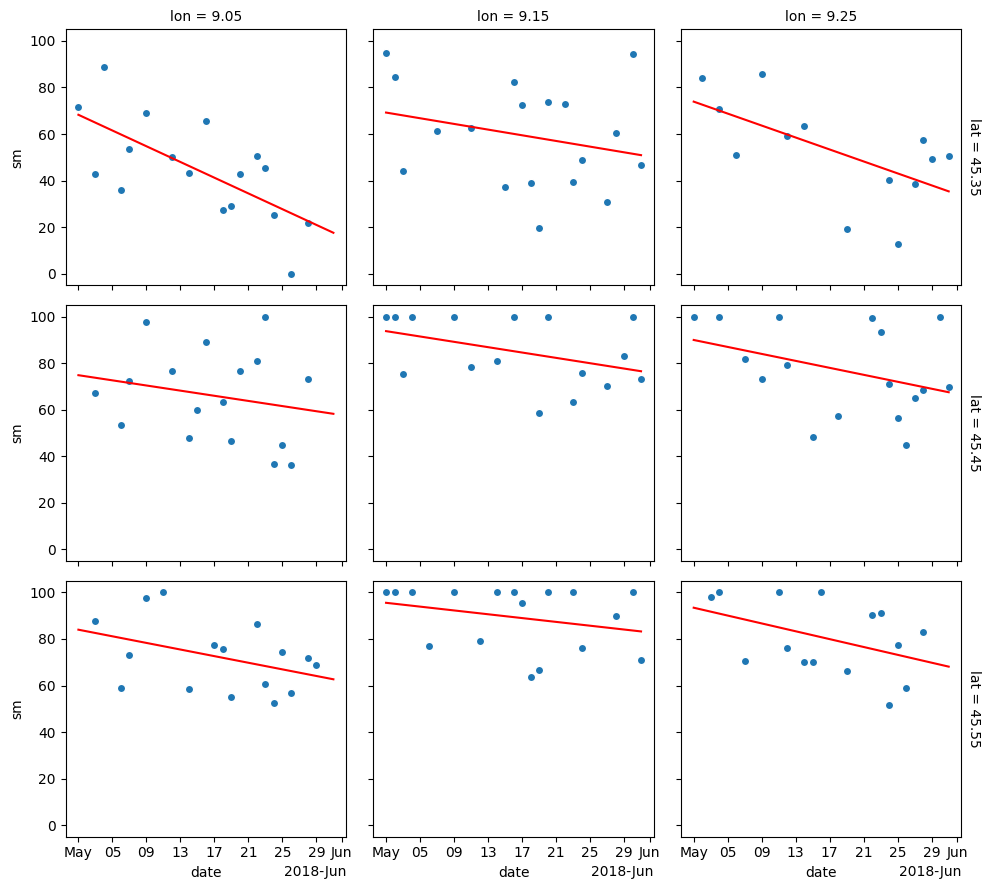

In [18]:
milan_grid_ssm = full_grid_ssm.sel(lat=slice(45.3, 45.6), lon=slice(9.0, 9.3))
regression = milan_grid_ssm.polyfit(dim="date", deg=1)
regression_lines = (milan_grid_ssm["date"].astype(np.float32) * regression.polyfit_coefficients.sel(degree=1) + regression.polyfit_coefficients.sel(degree=0))
facets = milan_grid_ssm.plot.scatter(row="lat", col="lon", x="date")
# plot regression lines
for i, _ in enumerate(facets.axs):
    for j, ax in enumerate(_):
        ax.plot(regression_lines.date, regression_lines.isel(lat=i, lon=j) ,color="red")

Now we can try the same somewhere in the alps and compare the trends.

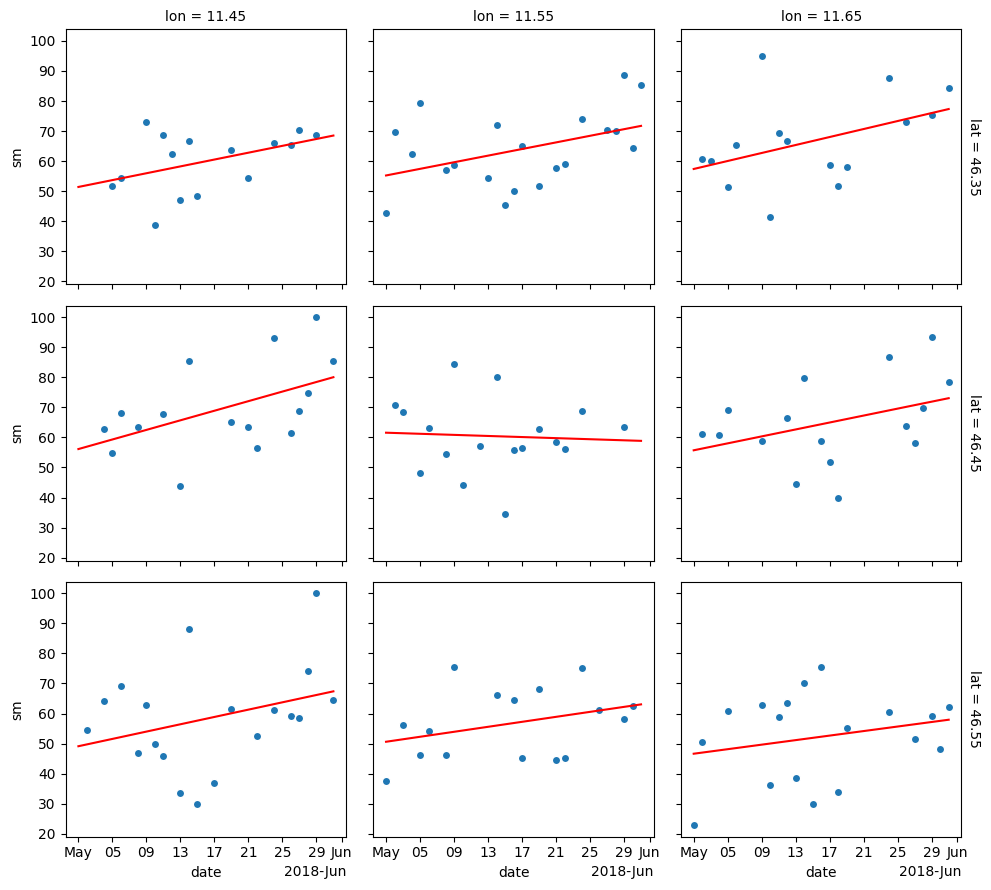

In [19]:

mountain_grid_ssm = full_grid_ssm.sel(lat=slice(46.3, 46.6), lon=slice(11.4, 11.7))
regression = mountain_grid_ssm.polyfit(dim="date", deg=1)
regression_lines = (mountain_grid_ssm["date"].astype(np.float32) * regression.polyfit_coefficients.sel(degree=1) + regression.polyfit_coefficients.sel(degree=0))
facets = mountain_grid_ssm.plot.scatter(row="lat", col="lon", x="date")
# plot regression lines
for i, _ in enumerate(facets.axs):
    for j, ax in enumerate(_):
        ax.plot(regression_lines.date, regression_lines.isel(lat=i, lon=j) ,color="red")

## Converting Native files to NetCDF

We just had a nice lesson for a situation where all the swath products intersecting our region of interest during our period of interest will fit on our disk and in memory. What if we want to do an analysis of a smallish area over a much longer time period? We can do some clipping as we download the files to avoid filling our hard drive and RAM with data we don't need.

It would also be nice to have all the data as netcdf files, since these are much nicer to use with packages like xarray and dask, which will help us manage memory and parallelism.

Here is a simple function that will iterate through an EODAG search result and convert them all to NetCDF files, clipping them to a region of interest as we go if desired. By default this is all it does, but if you know you can do away with the original swath files, you can set `delete_original=True` to remove them after conversion. This isn't implemented as part of the ascat package, but you can copy it for your own scripts if you find it useful.
<a id='to_netcdf'></a>

In [20]:
import shutil

def trim_ascat_data_to_roi(ds, footprint):
    ds = ds.sel(obs=(ds.lon > footprint["lonmin"])
                & (ds.lat > footprint["latmin"])
                & (ds.lon < footprint["lonmax"])
                & (ds.lat < footprint["latmax"]))
    return ds

def convert_ascat_native_to_netcdf(
        products,
        native_reader,
        footprint=None,
        output_directory=None,
        delete_original=False
):
    for product in products:
        # Download the product and read its data
        dl_dir = product.download()
        dl_dir = Path(dl_dir)
        fname = dl_dir/f"{dl_dir.name}.nat"
        product_file = native_reader(fname)
        data, _ = product_file.read(to_xarray=True)
        nc_fname = f"{dl_dir.name}.nc"

        if footprint is not None:
            # Trim the data to the region of interest
            data = trim_ascat_data_to_roi(data, footprint)
            # It's best to append "TRIMMED_" to the original filename,
            # to indicate it does not contain all the original data.
            # You might want a more sophisticated way of naming the file
            # to indicate the exact region.
            nc_fname = f"TRIMMED_{nc_fname}"

        # write to netcdf in the same location as the original product directory
        # if an output directory is not provided
        output_directory = output_directory or dl_dir.parent
        nc_fname = output_directory/nc_fname
        data.to_netcdf(nc_fname)

        # remove the original product directory and its contents, if requested
        if delete_original:
            shutil.rmtree(dl_dir)

In [21]:
netcdf_directory = Path("/tmp/eodag_eumetsat_nc")
netcdf_directory.mkdir(exist_ok=True)
convert_ascat_native_to_netcdf(products, AscatL2File, footprint=footprint, output_directory=netcdf_directory)

Let's try reading them back in. Now that we have normal netCDF files, we no longer need a special native reader to open them up, we can just use xarray.

In [22]:
ds = xr.open_mfdataset(netcdf_directory.glob("*.nc"), combine="nested", concat_dim="obs", engine="netcdf4")
ds

<xarray.Dataset> Size: 17MB
Dimensions:           (obs: 88803, beam: 3)
Coordinates:
    lon               (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    lat               (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    time              (obs) datetime64[ns] 710kB dask.array<chunksize=(173,), meta=np.ndarray>
Dimensions without coordinates: obs, beam
Data variables: (12/31)
    f_land            (obs, beam) float32 1MB dask.array<chunksize=(173, 3), meta=np.ndarray>
    sat_track_azi     (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    abs_line_number   (obs) int32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    param_db_version  (obs) uint16 178kB dask.array<chunksize=(173,), meta=np.ndarray>
    warp_nrt_version  (obs) uint16 178kB dask.array<chunksize=(173,), meta=np.ndarray>
    node_num          (obs) float64 710kB dask.array<chunksize=(173,), meta=np.ndarray>
    ...                ...
    frozen_prob       (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    wetland           (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    topo              (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    kp                (obs, beam) float32 1MB dask.array<chunksize=(173, 3), meta=np.ndarray>
    swath_indicator   (obs) float32 355kB dask.array<chunksize=(173,), meta=np.ndarray>
    sat_id            (obs) float64 710kB dask.array<chunksize=(173,), meta=np.ndarray>
Attributes:
    spacecraft_id:  2
    orbit_start:    60068
    sat_id:         3